In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
sys.path.append('..')
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, DVILoss, DummyTemporalLoss
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import VISTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from trustVis.sampeling import CriticalSampling
from singleVis.spatial_edge_constructor import Trustvis_SpatialEdgeConstructor, TrustvisTemporalSpatialEdgeConstructor

from singleVis.utils import _construct_fuzzy_complex

from singleVis.projector import VISProjector

import torch.nn.functional as F
########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" #

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


parser = argparse.ArgumentParser(description='Process hyperparameters...')

# get workspace dir
current_path = os.getcwd()

parent_path = os.path.dirname(current_path)

new_path = os.path.join(parent_path, 'training_dynamic')





CONTENT_PATH = '/home/yifan/dataset/case_study_mnist_backdoor'
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 42
EPOCH_END = 42
epoch = EPOCH_START
# EPOCH_START = 1
# EPOCH_END = 50
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = 1
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = 0
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]
VIS_MODEL_NAME = 'trustvis_tempo' ### saved_as VIS_MODEL_NAME.pth
# Define hyperparameters
GPU_ID = 0
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
print("device", DEVICE)           

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-18 21:39:41.135752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 21:39:41.670988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-18 21:39:41.671041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

device cuda:0
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 567.57it/s]


Successfully load the DVI visualization model for iteration 42
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 13392, 13398, 13630, 13657, 13674, 13700

100%|██████████| 300/300 [00:00<00:00, 7008.81it/s]


conf_error number: 90
vis_error 24
Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 987.13it/s] 


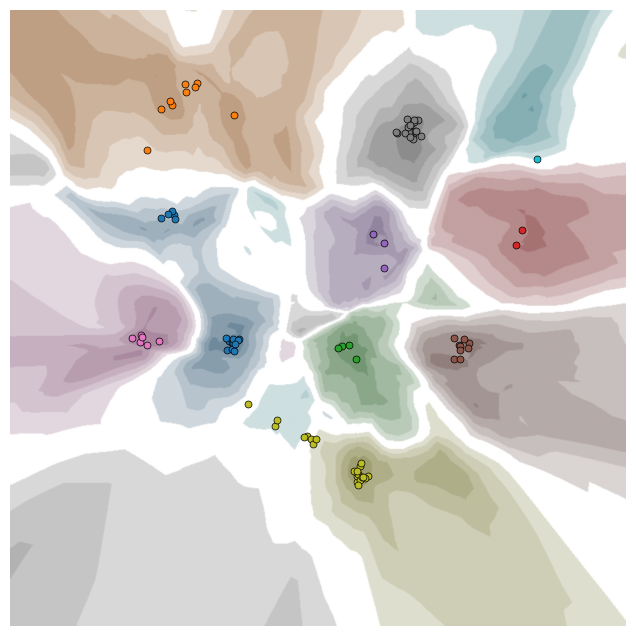

In [2]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])

pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)

emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
conf_error = []
for i in range(len(diff)):
    if abs(diff[i] - inv_diff[i]) > 0.3:
        conf_error.append(i)
print("conf_error number:", len(conf_error))
# from singleVis.eval.evaluate import *
# val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
k=0
inv_pred_Res = inv_pred.argmax(axis=1)
for i in range(len(inv_pred_Res)):
    if inv_pred_Res[i] != new_pred_Res[i]:
        k=k+1
print("vis_error",k)
vis = visualizer(data_provider, projector, 800, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [11]:
##### get_wrong_conf_2d region grids:
cof_error_emb = emb[conf_error]
grids = vis.get_grid(epoch, 400)
inv_grid = projector.batch_inverse(epoch, grids)

Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


In [12]:
diff = cof_error_emb[:, np.newaxis, :] - grids[np.newaxis, :, :]
dist_squared = np.sum(diff**2, axis=2)
k = 15 # Number of nearest neighbors to find
# Find the indices of the 10 nearest neighbors for each sample in cof_error_emb
nearest_neighbor_indices = np.argpartition(dist_squared, k, axis=1)[:, :k]
##### os the 2d embedding's nearest 15 neibour should be used as negative samples
neg_grids = grids[nearest_neighbor_indices]
print(neg_grids.shape)

(917, 15, 2)


In [13]:
org_data = train_data[conf_error]
from sklearn.neighbors import NearestNeighbors
high_neigh = NearestNeighbors(n_neighbors=15, radius=0.4)
high_neigh.fit(inv_grid)
"""
    for each conf_error point, we calculate its k nearest high dimensional grids
"""
knn_dists, knn_indices = high_neigh.kneighbors(org_data, n_neighbors=15, return_distance=True)
pos_grids = grids[knn_indices]
print(pos_grids.shape)

(917, 15, 2)


In [51]:
#### next we will retrain the model that freeze decoder: inv_grid is fixed. 

In [6]:
spatial_cons = Trustvis_SpatialEdgeConstructor(data_provider, epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
edge_to, edge_from, probs, pred_probs, feature_vectors, attention = spatial_cons.construct()

train data (60000, 512)


100%|██████████| 300/300 [00:00<00:00, 7129.53it/s]

Thu Apr 18 19:31:31 2024 Building RP forest with 17 trees


Thu Apr 18 19:31:32 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Gradients calculation: 54.00 seconds	softmax with temperature: 0.00 seconds


In [1]:

from abc import ABC, abstractmethod
import torch
from torch import nn
from singleVis.backend import convert_distance_to_probability, compute_cross_entropy
from scipy.special import softmax
import torch.nn.functional as F
import torch.optim as optim
import os


        
import torch
torch.manual_seed(0)  # fixed seed
torch.cuda.manual_seed_all(0)
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr

import json
from datetime import datetime

class UmapLoss_refine_conf(nn.Module):
    def __init__(self, negative_sample_rate, device,  data_provider, epoch, net, error_conf, neg_grid, pos_grid,fixed_number = 5, _a=1.0, _b=1.0, repulsion_strength=1.0):
        super(UmapLoss_refine_conf, self).__init__()

        self._negative_sample_rate = negative_sample_rate
        self._a = _a,
        self._b = _b,
        self._repulsion_strength = repulsion_strength
        self.DEVICE = torch.device(device)
        self.data_provider = data_provider
        self.epoch = epoch
        self.net = net
        self.model_path = os.path.join(self.data_provider.content_path, "Model")
        self.fixed_number = fixed_number
        
        self.error_conf = torch.tensor(error_conf)
        self.neg_grid = torch.tensor(neg_grid)
        self.pos_grid = torch.tensor(pos_grid)

        model_location = os.path.join(self.model_path, "{}_{:d}".format('Epoch', epoch), "subject_model.pth")
        self.net.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")),strict=False)
        self.net.to(self.DEVICE)
        self.net.train()

        for param in net.parameters():
            param.requires_grad = False

        self.pred_fn = self.net.prediction

    @property
    def a(self):
        return self._a[0]

    @property
    def b(self):
        return self._b[0]

    def forward(self, edge_to_idx, edge_from_idx, embedding_to, embedding_from, probs, pred_edge_to, pred_edge_from,edge_to, edge_from,recon_to, recon_from,a_to, a_from,recon_pred_edge_to,recon_pred_edge_from,curr_model,iteration):
        batch_size = embedding_to.shape[0]
        # get negative samples
        embedding_neg_to = torch.repeat_interleave(embedding_to, self._negative_sample_rate, dim=0)
        pred_edge_to_neg_Res = torch.repeat_interleave(pred_edge_to, self._negative_sample_rate, dim=0)
        repeat_neg = torch.repeat_interleave(embedding_from, self._negative_sample_rate, dim=0)
        pred_repeat_neg = torch.repeat_interleave(pred_edge_from, self._negative_sample_rate, dim=0)
        randperm = torch.randperm(repeat_neg.shape[0])
        embedding_neg_from = repeat_neg[randperm]
        pred_edge_from_neg_Res = pred_repeat_neg[randperm]
        indicates = self.filter_neg(pred_edge_from_neg_Res, pred_edge_to_neg_Res)

        #### strategy confidence: filter negative
        embedding_neg_to = embedding_neg_to[indicates]
        embedding_neg_from = embedding_neg_from[indicates]
        

        neg_num = len(embedding_neg_from)
        
        
        #### identify if the conf error is in the current pair #####################################
    
        conf_e_from = []
        conf_e_to_pos = []
        conf_e_to_neg = []

            
        mask_to = torch.isin(edge_to_idx, self.error_conf)
        mask_from = torch.isin(edge_from_idx, self.error_conf)
        conf_e_indices_to = torch.nonzero(mask_to, as_tuple=True)[0]
        conf_e_indices_from = torch.nonzero(mask_from, as_tuple=True)[0]

        filtered_to_idx = edge_to_idx[conf_e_indices_to]
        filtered_from_idx = edge_from_idx[conf_e_indices_from]

        for i,org_index in enumerate(filtered_to_idx):
            indicates = (self.error_conf == org_index).nonzero(as_tuple=True)[0]
            indicates= indicates[0].item()
            neg_grids = self.neg_grid[indicates].squeeze()
            pos_grids = self.pos_grid[indicates].squeeze()
            
            # Append the matched negative grids and the corresponding embedding
            # org_emb = torch.repeat_interleave(pred_edge_to, self._negative_sample_rate, dim=0)
            conf_e_from.extend([embedding_to[i]] * len(neg_grids))  
            conf_e_to_pos.extend(pos_grids)
            conf_e_to_neg.extend(neg_grids)
        
        for i,org_index in enumerate(filtered_from_idx):
            indicates = (self.error_conf == org_index).nonzero(as_tuple=True)[0]
            neg_grids = self.neg_grid[indicates].squeeze()
            pos_grids = self.pos_grid[indicates].squeeze()
            # Append the matched negative grids and the corresponding embedding
            
            conf_e_from.extend([embedding_to[i]] * len(neg_grids))  
            conf_e_to_pos.extend(pos_grids)
            conf_e_to_neg.extend(neg_grids)
            
        # Convert lists to tensors
        if len(conf_e_to_pos) > 0:
            conf_e_from = torch.stack(conf_e_to_pos).to(self.DEVICE)
            conf_e_to_pos = torch.stack(conf_e_to_pos).to(self.DEVICE)
            conf_e_to_neg = torch.stack(conf_e_to_neg).to(self.DEVICE)
            conf_pos_distance =  torch.norm(conf_e_from - conf_e_to_pos, dim=1).to(self.DEVICE)
            conf_neg_distance = torch.norm(conf_e_from - conf_e_to_pos, dim=1).to(self.DEVICE)
        else:
            conf_pos_distance = torch.tensor([], device=self.DEVICE)
            conf_neg_distance = torch.tensor([], device=self.DEVICE)
            
 

        positive_distance = torch.norm(embedding_to - embedding_from, dim=1)
        negative_distance = torch.norm(embedding_neg_to - embedding_neg_from, dim=1)
        #  distances between samples (and negative samples)
        positive_distance_mean = torch.mean(positive_distance)
        negative_distance_mean = torch.mean(negative_distance)

        #### dynamic labeling
        pred_edge_to_Res = pred_edge_to.argmax(axis=1)
        pred_edge_from_Res = pred_edge_from.argmax(axis=1)

        is_pred_same = (pred_edge_to_Res.to(self.DEVICE) == pred_edge_from_Res.to(self.DEVICE))
        is_pred_same = is_pred_same.to(self.DEVICE)
        pred_edge_to = pred_edge_to.to(self.DEVICE)
        pred_edge_from = pred_edge_from.to(self.DEVICE)

        recon_pred_to_Res = recon_pred_edge_to.argmax(axis=1)
        recon_pred_from_Res = recon_pred_edge_from.argmax(axis=1)


        temp = 0.001
        recon_pred_to_softmax = F.softmax(recon_pred_edge_to / temp, dim=-1)
        recon_pred_from_softmax = F.softmax(recon_pred_edge_from / temp, dim=-1)

        pred_to_softmax = F.softmax(pred_edge_to / temp, dim=-1)
        pred_from_softmax = F.softmax(pred_edge_from / temp, dim=-1)
        
        recon_pred_to_softmax = torch.Tensor(recon_pred_to_softmax.to(self.DEVICE))
        recon_pred_from_softmax = torch.Tensor(recon_pred_from_softmax.to(self.DEVICE))
        #### umap loss
        distance_embedding = torch.cat(
            (
                positive_distance,
                conf_pos_distance,
                negative_distance,
                conf_neg_distance
            ),
            dim=0,
        )
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self.a, self.b
        )
        probabilities_distance = probabilities_distance.to(self.DEVICE)

        probabilities_graph = torch.cat(
        (
            probs,
            torch.ones(len(conf_pos_distance)).to(self.DEVICE), # ground truth grid points
            torch.zeros(neg_num + len(conf_neg_distance)).to(self.DEVICE)
        ),dim=0)

        probabilities_graph = probabilities_graph.to(device=self.DEVICE)

        # compute cross entropy
        (_, _, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self._repulsion_strength,
        )  


        batch_margin = positive_distance_mean +  (negative_distance_mean - positive_distance_mean) * (1-probs)
        init_margin = (1.0 - is_pred_same.float()) * batch_margin

        margin = init_margin
        
        margin_loss = F.relu(margin.to(self.DEVICE) - positive_distance.to(self.DEVICE)).mean()
        
        umap_l = torch.mean(ce_loss).to(self.DEVICE) 
        margin_loss = margin_loss.to(self.DEVICE)

        if torch.isnan(margin_loss):
            margin_loss = torch.tensor(0.0).to(margin_loss.device)

        return umap_l, margin_loss, umap_l+margin_loss

    def filter_neg(self, neg_pred_from, neg_pred_to, delta=1e-1):
        neg_pred_from = neg_pred_from.cpu().detach().numpy()
        neg_pred_to = neg_pred_to.cpu().detach().numpy()
        neg_conf_from =  np.amax(softmax(neg_pred_from, axis=1), axis=1)
        neg_conf_to =  np.amax(softmax(neg_pred_to, axis=1), axis=1)
        neg_pred_edge_from_Res = neg_pred_from.argmax(axis=1)
        neg_pred_edge_to_Res = neg_pred_to.argmax(axis=1)
        condition1 = (neg_pred_edge_from_Res==neg_pred_edge_to_Res)
        condition2 = (neg_conf_from==neg_conf_to)
        # condition2 = (np.abs(neg_conf_from - neg_conf_to)< delta)
        indices = np.where(~(condition1 & condition2))[0]
        return indices
from singleVis.losses import ReconstructionLoss, DVILoss, DummyTemporalLoss
temporal_loss_fn = DummyTemporalLoss(DEVICE)
recon_loss_fn = ReconstructionLoss(beta=1.0)
umap_loss_fn = UmapLoss_refine_conf(negative_sample_rate, DEVICE, data_provider, epoch,net, conf_error, neg_grids,pos_grids,100, _a, _b,  repulsion_strength=1.0)
criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)
            

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'DEVICE' is not defined

In [16]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
state_dict =  torch.load(os.path.join(CONTENT_PATH, "Model","Epoch_{}".format(epoch),"{}.pth".format(VIS_MODEL_NAME)))["state_dict"]
model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
pred_list = data_provider.get_pred(epoch, feature_vectors)
dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, pred_probs,pred_list)
        
n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(pred_probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(pred_probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)
        
trainer = VISTrainer(model,criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)
trainer.train(PATIENT, 3,data_provider,epoch,True)

        # save result
save_dir = data_provider.model_path
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 6710.31it/s]


epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6874.78it/s]


#train# PPR: 1.00 in epoch 42, vis error:24
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10432.04it/s]


#test# PPR: 0.99 in epoch 42, vis error:83
freezed
freezed
freezed
freezed
freezed
freezed
freezed
freezed


100%|██████████| 1955/1955 [00:59<00:00, 33.03it/s]


umap:0.6186	recon_l:0.1366	new_loss:0.0017	loss:0.7570
epoch:2
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6957.23it/s]


#train# PPR: 1.00 in epoch 42, vis error:11
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10617.95it/s]


#test# PPR: 0.99 in epoch 42, vis error:104
freezed
freezed
freezed
freezed
freezed
freezed
freezed
freezed


100%|██████████| 1955/1955 [01:02<00:00, 31.51it/s]


umap:0.6168	recon_l:0.1348	new_loss:0.0015	loss:0.7531
epoch:3
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6917.49it/s]


#train# PPR: 1.00 in epoch 42, vis error:15
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10445.02it/s]


#test# PPR: 0.99 in epoch 42, vis error:109
freezed
freezed
freezed
freezed
freezed
freezed
freezed
freezed


100%|██████████| 1955/1955 [01:03<00:00, 30.64it/s]

umap:0.6153	recon_l:0.1346	new_loss:0.0014	loss:0.7513
Time spend: 186.01 for training vis model...
Successfully save visualization model...


100%|██████████| 300/300 [00:00<00:00, 7087.69it/s]


Successfully load the DVI visualization model for iteration 42
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 13392, 13398, 13630, 13657, 13674, 13700

100%|██████████| 300/300 [00:00<00:00, 7092.68it/s]


conf_error number: 90
Thu Apr 18 21:27:27 2024 Building RP forest with 17 trees
Thu Apr 18 21:27:28 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Apr 18 21:28:58 2024 Building RP forest with 17 trees
Thu Apr 18 21:28:59 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
nn 1.4509166666666666
Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:02<00:00, 1202.30it/s]


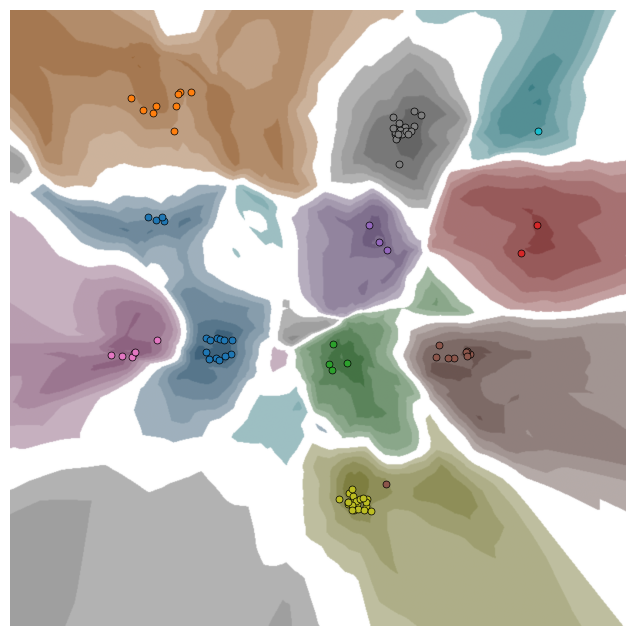

In [4]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
# print('diff',diff[[[492, 783, 835, 871, 951, 1052,]]])

path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)
emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
# conf_error = []
# for i in range(len(diff)):
#     if abs(diff[i] - inv_diff[i]) > 0.3:
#         conf_error.append(i)
print("conf_error number:", len(conf_error))
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
from singleVis.eval.evaluate import *
val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
print("nn",val)
vis = visualizer(data_provider, projector, 800, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [18]:
val

1.4509333333333334

In [19]:
k=0
for i in range(len(conf_error)):
    index = conf_error[i]
    if abs(diff[index]-inv_diff[index]) > 0.3:
        k=k+1
print(k)

55


In [20]:
k=0
for i in range(60000):
    if abs(diff[i]-inv_diff[i]) > 0.3:
        k=k+1
print(k)

175


In [109]:
k=0
inv_pred_Res = inv_pred.argmax(axis=1)
for i in range(len(inv_pred_Res)):
    if inv_pred_Res[i] != new_pred_Res[i]:
        k=k+1
k

82